# Final Data Science Project

## Name : KIMAYA KHILARE

## NUID : 002958773

# IMAGE CLASSIFICATION AND NOISE DETECTION 

## Abstract : 

In this project, I aim to take up couple of hundreds of images and try working on them by reducing the noise and detect them. All devices have signals that can be analog or digital have noise. Noises can be of various types. 
Removal of noise from a signal is often abbreviated as noise reduction technique. These techniques are applicable to only image and audio files. This process is carried out to enhance the image quality. There can be different types of imperfect pixels like the ones which are stuck that needs to be minimized to improve the signals. This minimization leads to better sharpness of the image to the human eye. 

A classification algorithm will be running on the images to find out the image distribution of images according to their class labels. This is a type of feature engineering where images are sorted according to their labels. Such a classification process was run for both the datasets. I will be further performing the Classification Algorithms like Random Forest, Support Vector Machine, Logistic Regression where I will be performing comparative analysis

For the noise reduction module, I am using  Variational Autoencoders technique. Variational Autoencoders is a Neural Network architecture

## Dataset : https://github.com/fastai/imagenette/tree/imagenette-noise

## PART 1: DATA EXPLORING 

### IMPORTING LIBRARIES 

In [102]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

In [103]:
import utils

In [104]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
matplotlib.rcParams["figure.dpi"] = 140
plt.style.use("seaborn")

In [107]:
from torchvision import transforms

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

Importing the dataset using Imagefolder and dataloader. ImageFolder class supports a powerful feature in composing the batch dataset. In most cases, when we build the batch dataset, arranging input data and its corresponding label in pairs is done manually. With the ImageFolder, however, this can be done much easier if the dataset is composed of images. DataLoader of torch.utils.data package is what actually returns the batch given the transformations and data directory that I set with the above Transform and ImageFolder class.

In [108]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/train", transform=test_transforms)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)

In [109]:
random_indicies = np.random.randint(0, len(train_dataset), 5)

batch = [train_dataset[rand_i][0] for rand_i in random_indicies]
labels = [train_dataset[rand_i][1] for rand_i in random_indicies]

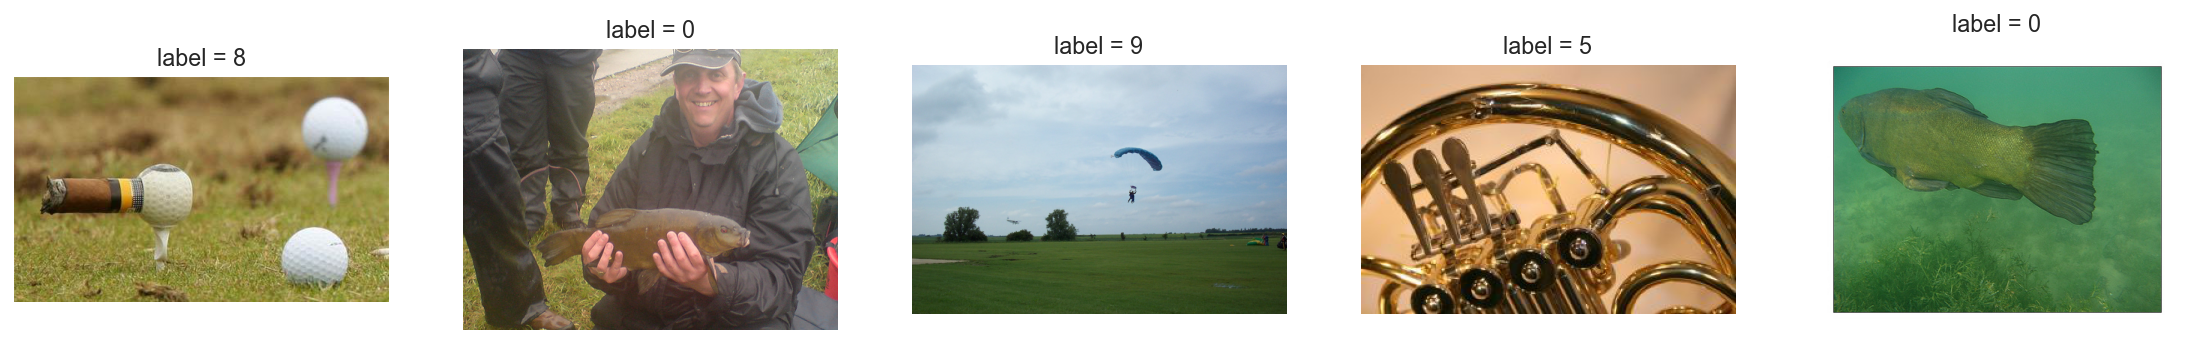

In [110]:
utils.show_batch(batch, labels, 5)

The dataset consists of 13,394 distinct images. The data is further divided into training and testing dataset. The ratio for training and testing data is set to be 70% and 30% respectively. So, training dataset has 9469 files and testing dataset has 3925 files.

In [111]:
len(train_dataset)

9469

Importing the testing data using ImageFolder and DataLoader

In [112]:
test_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/val", transform=test_transforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

In [113]:
len(test_dataset)

3925

In [114]:
image_filepaths = [x[0] for x in train_dataset.samples]

Function to get shape(Width,height) and labels of the image

In [115]:
def get_image_shapes(dataset):
    image_widths = []
    image_heights = []
    image_labels = []

    for image, label in dataset:
        width, height = image.shape[1], image.shape[2]
        image_widths.append(width)
        image_heights.append(height)
        image_labels.append(label)
        
    return np.array(image_widths), np.array(image_heights), np.array(image_labels)

In [116]:
train_widths, train_heights, train_labels = get_image_shapes(train_dataset)

### Detecting Outliers

Here, I am detecting the outliers and plotting the Train dataset Image size distribution

In [117]:
def plot_size_distribution(image_widths, image_heights, image_labels, title):
    plt.figure(figsize=(6, 4))

    for label in np.unique(image_labels):
        _widths = image_widths[image_labels == label]
        _heights = image_heights[image_labels == label]

        plt.scatter(x=_widths, y=_heights, label=f"label {label}", s=1.5)

    plt.legend(fontsize=6)
    plt.title(title)
    plt.xlabel("Width", fontsize=8)
    plt.ylabel("Height", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.show()

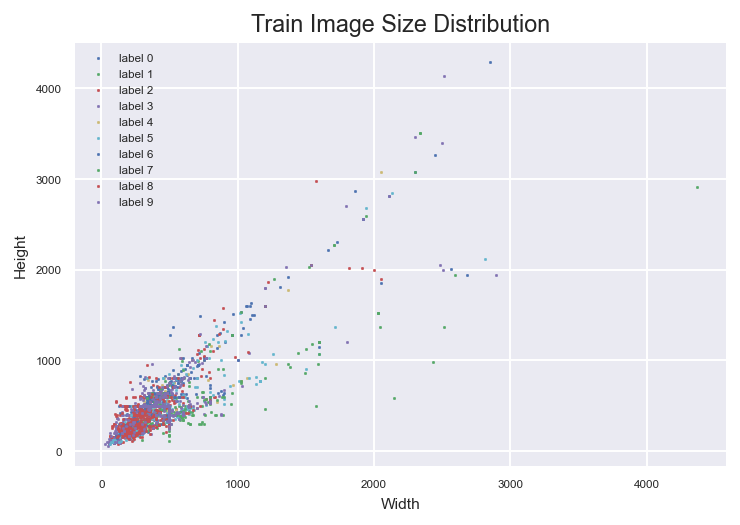

In [118]:
plot_size_distribution(train_widths, train_heights, train_labels, "Train Image Size Distribution")

Plotting the Test Image Size distribution

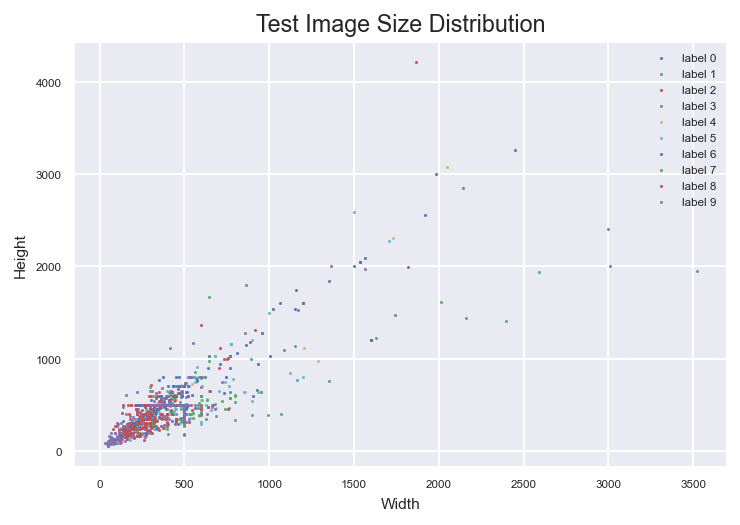

In [85]:
test_widths, test_heights, test_labels = get_image_shapes(test_dataset)
plot_size_distribution(test_widths, test_heights, test_labels, "Test Image Size Distribution")

It is quite evident from the above plot that the images are given different labels according to their size differences.

The driving factors of an image is the width and height. These two factors are usually the influencing factors of any image. 
A box plot was created on basis of these characteristics. Outliers can also be detected from the same.

In [119]:
def plot_width_height_box(image_widths, image_heights, title):
    plt.figure(figsize=(6, 5))
    plt.boxplot(
        x=[image_widths, image_heights],
        labels=["Widths", "Heights"], 
        flierprops=dict(markerfacecolor='g',marker='D'),
        whis=5
    )
    plt.title(title)
    plt.show()

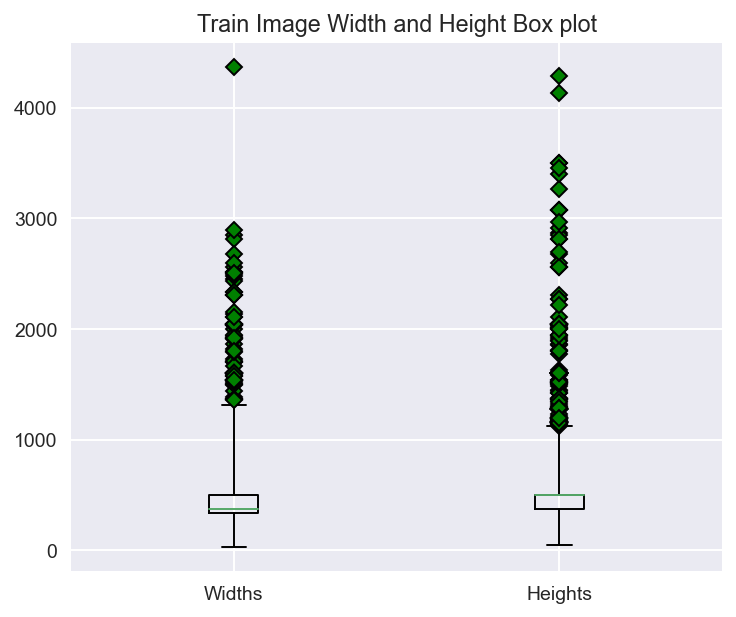

In [120]:
plot_width_height_box(train_widths, train_heights, "Train Image Width and Height Box plot")

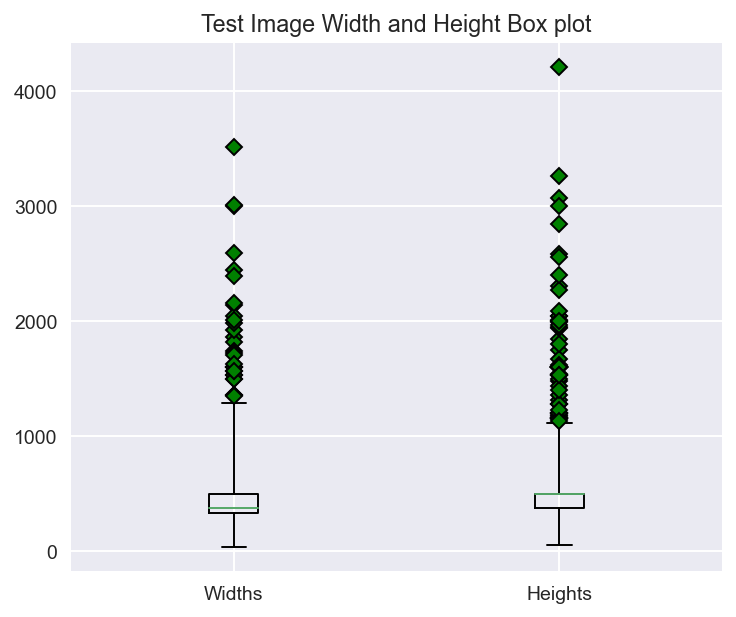

In [121]:
plot_width_height_box(test_widths, test_heights, "Test Image Width and Height Box plot")

It is quite evident from the above boxplot that there are many outliers for each feature. For training dataset, the outliers for width are usually between the range of 1200 to 3000 pixels with one exception above 4000 pixels. On contrary, the outliers for height ranges between 1000 pixels and 3700 pixels with a couple of exceptions being above 4000 pixels. For testing dataset, the outliers for width are usually between the range of 1200 to 2500 pixels with couple of exception above 3000 pixels. On contrary, the outliers for height ranges between 1000 pixels and 3000 pixels with a couple of exceptions being above 3000 pixels.  

In [122]:
big_image_indicies = np.where(train_widths > 2500)[0][:5]

In [123]:
batch = [train_dataset[i][0] for i in big_image_indicies]
labels = [train_dataset[i][1] for i in big_image_indicies]

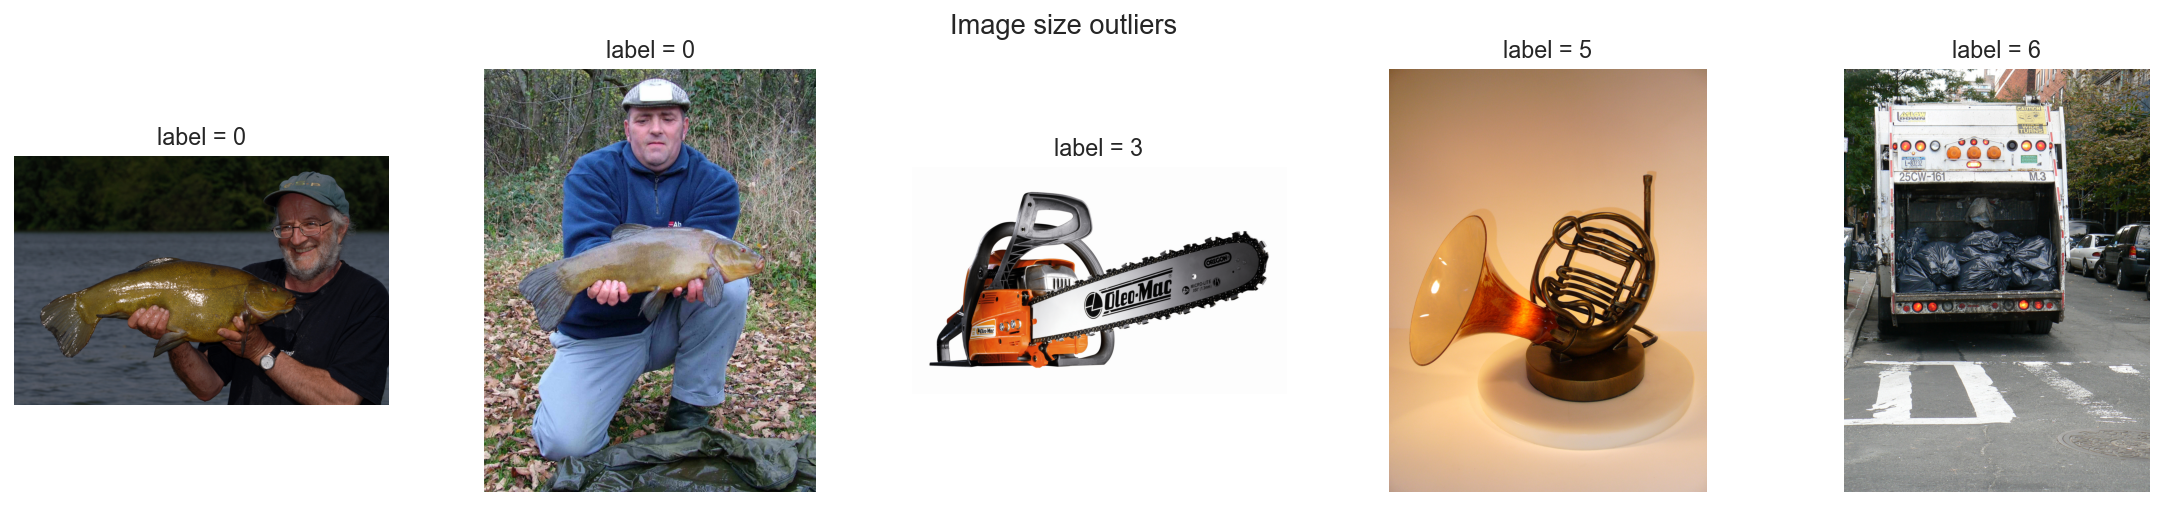

In [124]:
utils.show_batch(batch, labels, 5, "Image size outliers");

## Normalization

Normalization is a technique for creating datasets for the artificial intelligence problem statements. It generally alters the range of vector intensity data.  Over here, the images have also under gone data normalization. PyTorch is the implemented function which normalizes images on the fly. Normalization is done according to torch vision recommendation which is consistent for all the pretrained modules with mean [0.485, 0.456, 0.406] and std [0.229, 0.224, 0.225]. 

Normalization is an essential step as it ensures uniform distribution of pixel data. Later, during the training of the network it results in fast convergence. This is equivalent to a zero centered gaussian curve. The vector range is from 0 to 255 which is recommended to be normalized between 0 and 1. This will ensure that all the variable data is unified into one data range for further easier computations.


In [125]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [126]:
train_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/train", transform=test_transforms)

In [127]:
random_indicies = np.random.randint(0, len(train_dataset), 5)

batch = [train_dataset[rand_i][0] for rand_i in random_indicies]
labels = [train_dataset[rand_i][1] for rand_i in random_indicies]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


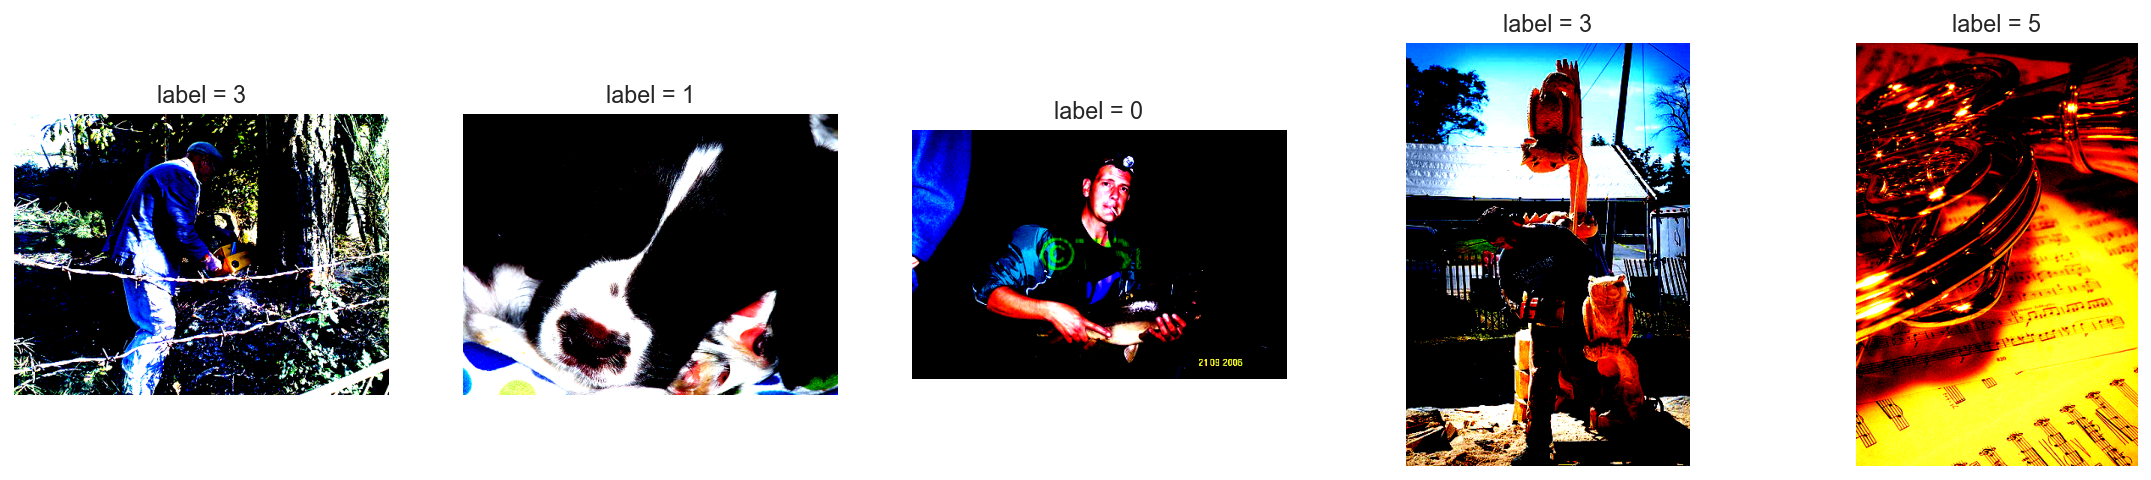

In [130]:
batch_plot = utils.show_batch(batch, labels, 5)

## Image Class Distribution

A classification program is run on the images to find out the image distribution of images according to their class labels. This is a type of feature engineering where images are sorted according to their labels. Such a classification process was run for both the datasets. 

In [131]:
list_train = train_dataset.samples

In [132]:
from collections import Counter

In [133]:
classes = list(map(lambda i: i[1], list_train))
class_freq = Counter(classes)

In [134]:
relative_values = np.array(list(class_freq.values())) / len(train_dataset) #calculate relative values for the plot

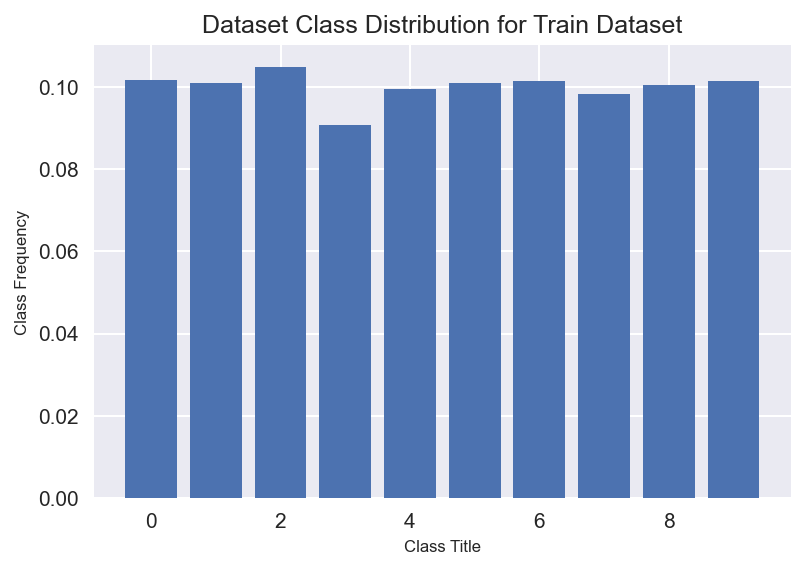

In [217]:
plt.bar(range(len(class_freq)), relative_values)
plt.title("Dataset Class Distribution for Train Dataset")
plt.xlabel("Class Title", fontsize=8)
plt.ylabel("Class Frequency", fontsize=8)
plt.show()

As you can observe in train dataset, the class frequency is almost same for all class labels. Only class with label 3 has slightly low class frequency as compared to other labels.

In [218]:
list_test = test_dataset.samples
# list_test

In [219]:
from collections import Counter

In [220]:
classes_test = list(map(lambda i: i[1], list_test))
class_freq_test = Counter(classes_test)
class_freq_test

Counter({0: 387,
         1: 395,
         2: 357,
         3: 386,
         4: 409,
         5: 394,
         6: 389,
         7: 419,
         8: 399,
         9: 390})

In [221]:
relative_values_data = np.array(list(class_freq_test.values())) / len(test_dataset)

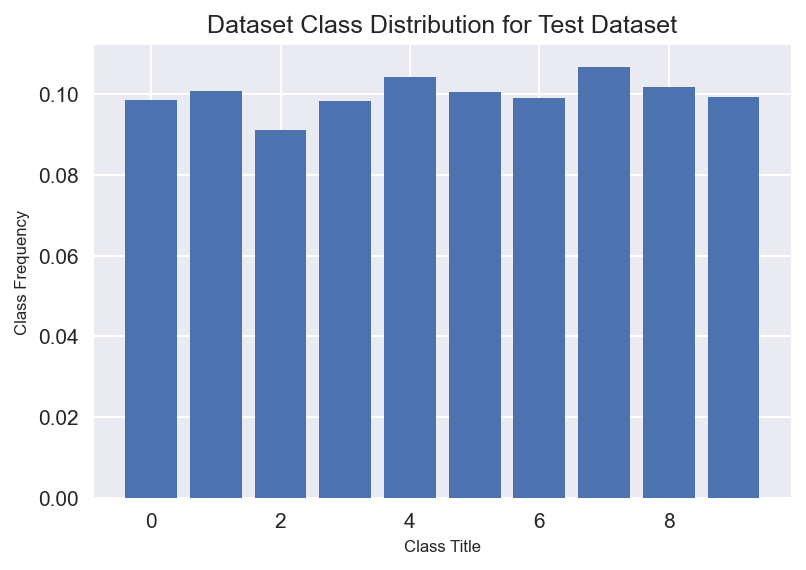

In [222]:
plt.bar(range(len(class_freq_test)), relative_values_data)
plt.title("Dataset Class Distribution for Test Dataset")
plt.xlabel("Class Title", fontsize=8)
plt.ylabel("Class Frequency", fontsize=8)
plt.show()

From the above two figures, it remarkably noticeable that there is not extreme difference between class distributions. Both the datasets have 10 class labels ranging from 0 to 9. 

## Data Preprocessing Part

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 5

### Add Grayscaling so we have less features
### Add Resizing the images to the pipeline

In [141]:
from torchvision import transforms



test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
])

In [142]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/train", transform=test_transforms)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [143]:
# random_indicies = np.random.randint(0, len(train_dataset), 5)

batch, labels = next(iter(train_dataloader))

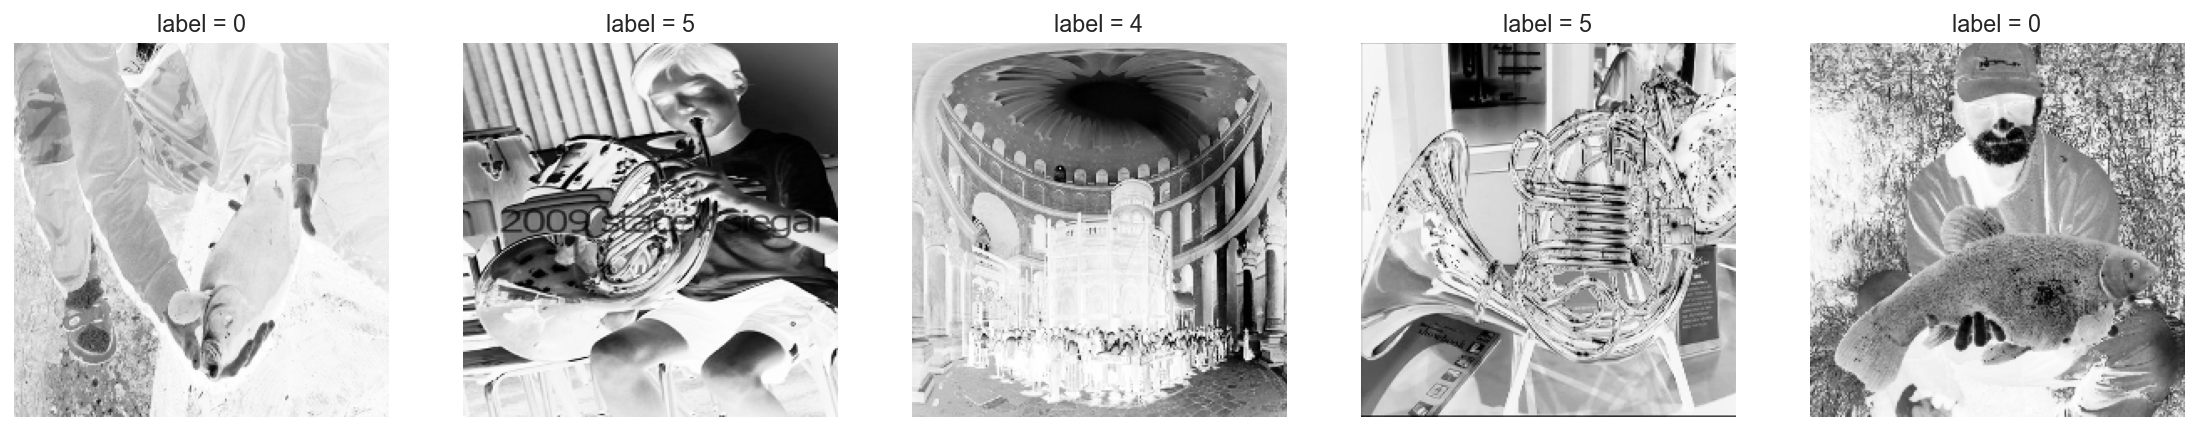

In [144]:
utils.show_batch(batch, labels, 5)

### Now we need to flatten images. Basically, I need to convert image of size 224x224 to a flat matrix with a lot of features 

In [145]:
# Create PyTorch Vision Transform to create a flatten array given an image

class FlattenImage:
    def __call__(self, image):
        """
        Take an image and reshape it to a 1-dimensional array
        """
        return image.reshape(image.shape[-1] * image.shape[-2])

In [146]:
from torchvision import transforms


#
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    FlattenImage()
])

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/train", transform=test_transforms)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [147]:
batch.shape

torch.Size([5, 1, 224, 224])

In [148]:
# Create numpy arrays for train and test data with a shape of: number of train images, number of flatten features
X_train = np.zeros((len(train_dataset), IMAGE_SIZE * IMAGE_SIZE))
y_train = np.zeros(len(train_dataset))

In [149]:
for i, (flatten_image, label) in enumerate(train_dataset):
    X_train[i] = flatten_image
    y_train[i] = label

In [150]:
print(X_train.shape, y_train.shape, sep="\n")

(9469, 50176)
(9469,)


#### Here by, I have got the flatten images through above transforms

### Create test dataset with the same approach

In [151]:
test_dataset = ImageFolder("C:/Users/kimay/Downloads/Project/imagenette2/val", transform=test_transforms)

X_test = np.zeros((len(test_dataset), IMAGE_SIZE * IMAGE_SIZE))
y_test = np.zeros(len(test_dataset))


for i, (flatten_image, label) in enumerate(test_dataset):
    X_test[i] = flatten_image
    y_test[i] = label

In [152]:
print("Train dataset shape:", X_train.shape)
print("Test dataset shape:", X_test.shape)

Train dataset shape: (9469, 50176)
Test dataset shape: (3925, 50176)


### Now, we have train and test datasets. However they have 50176 features which looks like too much for tree based models. We need to apply dimensionality reduction technique.

## PCA

There were 13,394 images in the whole dataset. These images were further divided into training and testing dataset. Training dataset contained 9469 images while testing dataset contained 3925 images. Both the dataset has images with 50176 features. So, using the reshape function from NumPy library, the dimension of the images which were too much for tree based models were reduced principal component analysis. PCA is a well-known unsupervised dimensionality reduction approach to lower dimensional space. We used PCA since we were confronted with the curse of dimensionality with 51706 features. So, from 51076 features, we reduced it to 10 PC components using the PCA algorithm. The images were normalized using gray scaling technique and flattening of images was also performed. This helped to convert multi-dimensional array into single dimensional array. Resizing the images to the pipeline, we converted an image of size 224x224 to a flat matrix with a lot of features using the flatten() function. We are dealing with a dataset which contains a large amount of images thus flattening helps in decreasing the memory as well as reducing the time to train the model.

### First we need to concatenate train and test splits to perform PCA in one time

In [153]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [154]:
from sklearn.decomposition import PCA

X_decomposed = PCA(n_components=10).fit_transform(X)

### We will save the data as csv table

In [155]:
import pandas as pd

In [156]:
df = pd.DataFrame(X_decomposed)
df["label"] = y.astype(np.int64)
df.to_csv("C:/Users/kimay/Downloads/Project/images_pca_composed.csv")

# Modelling and their Interpretations

#### Logistic Regression with hyper parameters "penalty=l2", solver ="lblgs" and "C=0.01"

In [224]:
import pandas as pd
df = pd.read_csv("C:/Users/kimay/Downloads/Project/images_pca_composed.csv")

X= df.iloc[:,1:-1]
y=df["label"]

In [225]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [226]:
lr = LogisticRegression(C=0.01, penalty="l2", tol=0.0001)
result=lr.fit(X_train, y_train)

In [227]:
pred = lr.predict_proba(X_test)
pred_classes = lr.predict(X_test)

print(
    f"Log Loss: {metrics.log_loss(y_test, pred)}",
    f"Accuracy: {metrics.accuracy_score(y_test, pred_classes)}",
    sep="\n"
)

Log Loss: 2.0551192999188146
Accuracy: 0.2720214989549119


Below, I am plotting the Confusion Matrix for the dataset to predict the accuracy of the model

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [231]:
cm = metrics.confusion_matrix(y_test, pred_classes)
print(cm)

[[ 83  31   6   8  39  30  57   5  49  14]
 [ 41 120  29  20  19  37  37   2  16  40]
 [ 22  32 123   8  28  25  41   1  18  31]
 [ 34  56  42  23  24  38  31   6  25  44]
 [ 31  26  12   1  95  47  43   6  39  33]
 [ 42  39  22  15  51  76  30  10  31  25]
 [ 20  14  50   9  38  14 136   2  30   8]
 [ 51  38  37  14  46  29  42   7  46  27]
 [ 44  16  13   4  46  31  25   4  91  69]
 [ 15  38  14  18  24  32  14   6  21 157]]


<AxesSubplot:>

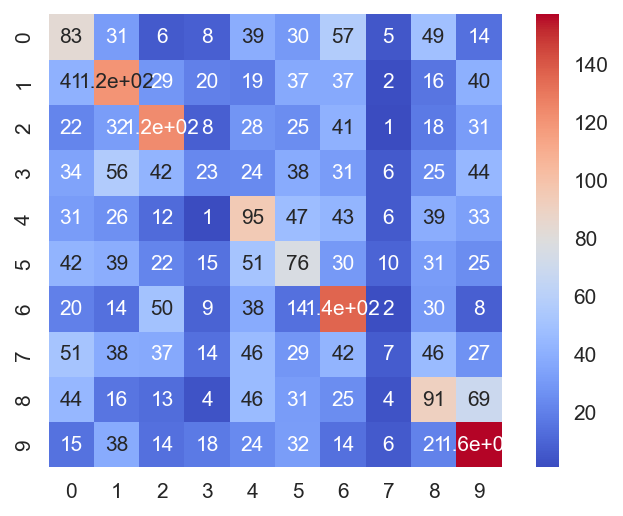

In [236]:
sns.heatmap(cm,annot=True,cmap='coolwarm')

Observing the heatmap, sufficient portion of the images are getting correctly classified as seen in the diagonals. Class labels 1,2,6,9 show higher accuracy in being classified whereas class label 3 and 7 have very low classification accuracy. 

RMSE 

In [234]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
rmse = sqrt(mean_squared_error(y_test, pred_classes)) 
rmse

3.6604542139267915

Mean square error(MSE)

In [162]:
import numpy as np

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 
mse(y_test,pred_classes)

13.625261272021499

In [163]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [164]:
lr = OneVsRestClassifier(LogisticRegression(C=0.01, penalty="l2", tol=0.0001, solver ="lbfgs"))
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_prob = lr.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)

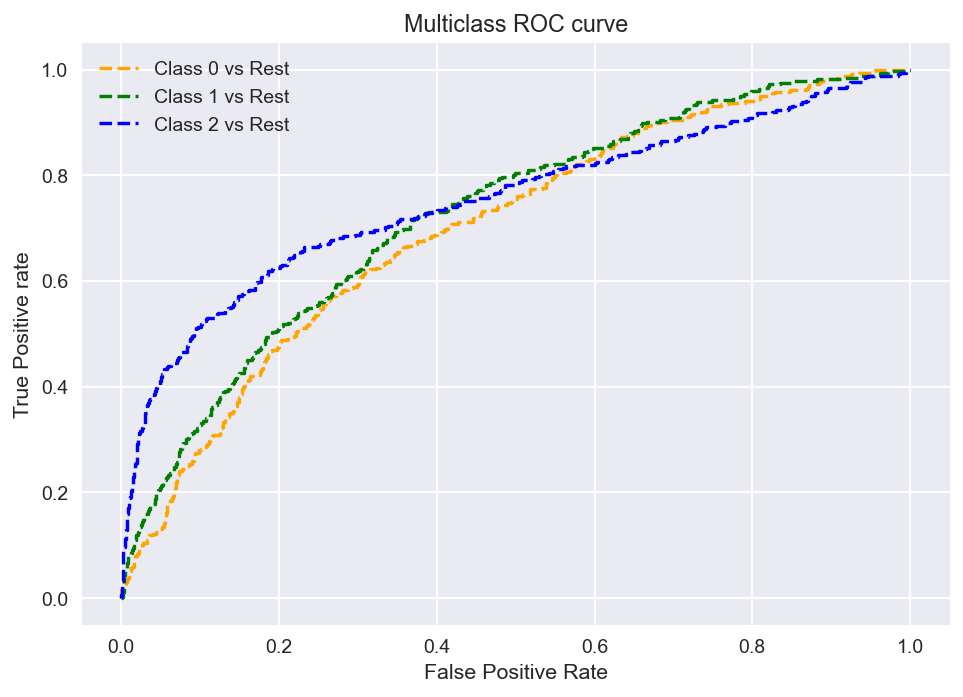

In [165]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [167]:
from sklearn.metrics import roc_auc_score

# auc scores
auc = roc_auc_score(y_test, pred_prob,multi_class="ovr")

print(auc)

# auc scores
auc = roc_auc_score(y_test, pred_prob,multi_class="ovo")


print(auc)

0.7045363823002351
0.7045612058936168


As we can infer, the accuracy by auc score which is near 70% and considered to be a good accuracy

### Random Forest

#### Performing GridSearch for Hyperparameters "n_estimators" and "max_features"

In [239]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


# define models and parameters
modelRF = RandomForestClassifier()
n_estimators = [ 100]
max_features = [ 'sqrt','log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=modelRF, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.332536 using {'max_features': 'sqrt', 'n_estimators': 100}
0.332536 (0.014082) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.331716 (0.015183) with: {'max_features': 'log2', 'n_estimators': 100}


sqrt parameter takes less square root of total number of features in single run as compared to log2. sqrt is generally preferred for classification problem whereas log2 is used for regression problem. So, sqrt is smaller than log2 and smaller the feature the lesser the overfitting. Therefore, considering this is a classification problem, max_features = sqrt yields better output as compared to max_features = log2.

In [240]:
from sklearn.metrics import log_loss
modelRF.fit(X_train, y_train)
Prob = modelRF.predict_proba(X_test)
pred_classes = modelRF.predict(X_test)
score = log_loss(y_test, Prob)
print(score)

2.0499905586208613


In [248]:
modelRF.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=552803267)

#### RMSE

In [241]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
rmse = sqrt(mean_squared_error(y_test, pred_classes)) 
rmse

3.4599616655078873

#### MSE

In [242]:
import numpy as np

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 
mse(y_test, pred_classes)

11.971334726784114

In [243]:
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100, max_features = "log2"))
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_prob = rf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)

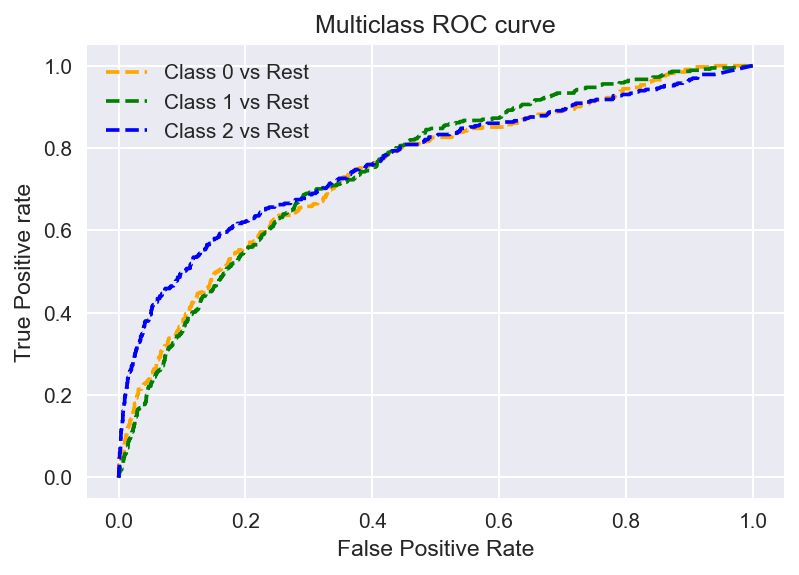

In [244]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [245]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, pred_prob,multi_class="ovr")
print(auc)

auc = roc_auc_score(y_test, pred_prob,multi_class="ovo")
print(auc)

0.7402755905019749
0.7403799213081915


The AUC values we got was (0.74). This means that almost 74% of the predictions are going to be correct.

### SVM (Support Vector Machine)

Support vector machine (SVM) is a supervised machine learning model that uses classification techniques. SVM models can categorize new text after being given sets of labeled training data for each category. It is a supervised machine learning technique that can be used to solve problems like classification and regression. It transforms your data using a technique known as the kernel trick, and then calculates an ideal boundary between the available outputs based on these alterations. The hyper parameters used for this model are as follows:

In [251]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#### Performing Grid Search with Hyper Parameters 'C','gamma' and 'kernel'

In [254]:
# define model and parameters
model = SVC()
kernel = ['sigmoid','rbf']
C = [ 0.1]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.319098 using {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.155617 (0.012947) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.319098 (0.012579) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [178]:
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)

pred = svc_model.predict_proba(X_test)
pred_classes = svc_model.predict(X_test)

print(
    f"Log Loss: {metrics.log_loss(y_test, pred)}",
    sep="\n"
)
  

Log Loss: 1.8913584980474583


In [179]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
rmse = sqrt(mean_squared_error(y_test, pred_classes)) 
rmse

3.4668157703500664

In [180]:
import numpy as np

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 
mse(y_test,pred_classes)

12.018811585547924

In [181]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
svc_model = OneVsRestClassifier(SVC(kernel="rbf", C=0.1, probability = True))
svc_model.fit(X_train, y_train)
pred = svc_model.predict(X_test)
pred_prob = svc_model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)


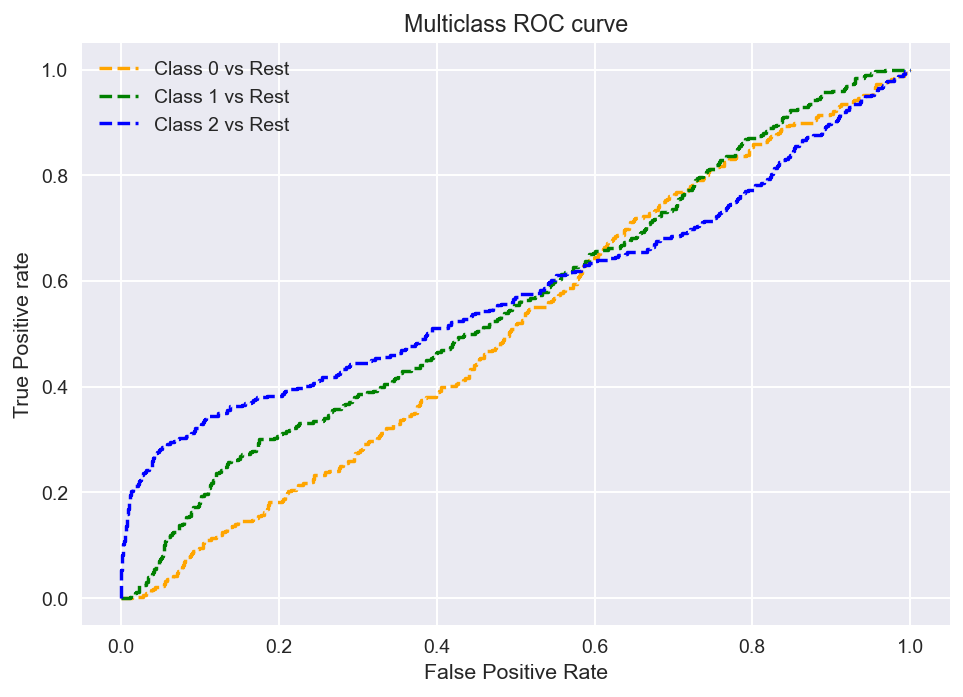

In [182]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [183]:
from sklearn.metrics import roc_auc_score

# auc scores
auc = roc_auc_score(y_test, pred_prob,multi_class="ovr")


print(auc)

# auc scores
auc = roc_auc_score(y_test, pred_prob,multi_class="ovo")


print(auc)

0.5524026788858356
0.5520825659786608


The AUC values we got was (0.55). This means that almost 55% of the predictions are going to be correct.

# VAE Noising and Denoising

Variational Autoencoders is a Neural Network architecture, which consists of two parts: encoder and decoder. Encoder compresses the image to a vector with latent variables, while decoder tries to reconstruct the original image given the latent vector. Data is going to be fed to a variational auto encoder, then after compressing and decompressing, a comparison between the output image and original non-noisy image will be conducted. To train such a model we need to use a reconstruction loss function which calculates the difference between a reconstructed image and non-noisy original image. In this case model will learn how it avoid encoding noise along with the rest of the image and get rid of it in the latent vector. Every time model is penalized for producing noisy image, it will learn more and more of how to get rid of this irrelevant information.

For this part, I am selecting the subset of the orignal dataset i.e. Imagenett. The dataset has only 10 labels which are defined in the next line.

In [191]:
train_data_dir = "C:/Users/kimay/Downloads/Project/imagenette2-320/train"
test_data_dir = "C:/Users/kimay/Downloads/Project/imagenette2-320/val"

I will first define a List of the Labels

In [192]:
CLASSES = [
    "tench",
    "English springer",
    "cassette player",
    "chainsaw", 
    "church",
    "French horn",
    "garbage truck",
    "gas pump", 
    "golf ball",
    "parachute"
]

In [193]:
import matplotlib
import matplotlib.pyplot as plt

In [194]:
%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 150

In [195]:
import typing as t
from torchvision.datasets import ImageFolder

class VAEImageFolder(ImageFolder):
    def __init__(self, transform_noisy=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform_noisy = transform_noisy
        num_cpus=8
    
    def __getitem__(self, index: int) -> t.Tuple[t.Any, t.Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        sample_noisy = self.transform_noisy(sample)
        
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return sample, sample_noisy, target

Function to generate random noise and add the generated noise to the image

In [196]:
class RandomNoise:
    def __init__(self, noise_factor=0.14):
        self.noise_factor = noise_factor
        
    def __call__(self, image_tensor):
        return image_tensor + torch.randn_like(image_tensor) * self.noise_factor
#         return torch.clip(noisy_image, 0., 1.)

Importing torch and Pytorch. Preprocessing the dataset for training by applying transforms like Resizing and Normalizing.

In [197]:
import torch
import pytorch_lightning as pl
import torchvision
from torchvision import transforms


IMAGE_SIZE = 128

class ImagenetteDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Preprocessing steps applied to validation and test set.
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        self.trainsform_noisy = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
            RandomNoise(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
        
        self.transform_example = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        ])
        self.transform_example_noisy = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
            RandomNoise(),
        ])
        
        self.num_classes = 10
        

    def setup(self, stage=None):
        # build dataset
        self.train_dataset = VAEImageFolder(root=train_data_dir)
        self.train_dataset.transform = self.transform
        self.train_dataset.transform_noisy = self.trainsform_noisy
        
        self.example_dataset = VAEImageFolder(root=test_data_dir)
        self.example_dataset.transform = self.transform_example
        self.example_dataset.transform_noisy = self.transform_example_noisy
        
        self.val_dataset = VAEImageFolder(root=test_data_dir)
        self.val_dataset.transform = self.transform
        self.val_dataset.transform_noisy = self.trainsform_noisy
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True
        )
    
    def example_dataloader(self):
        return torch.utils.data.DataLoader(self.example_dataset, batch_size=5, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=5)
    

In [198]:
dm = ImagenetteDataModule(batch_size=120)
dm.setup()

In [257]:
batch, batch_noisy, labels = next(iter(dm.example_dataloader()))

Function to plot the batch of image and their corresponding labels.

In [200]:
def plot_batch(batch, labels):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
    
    for i, (img, label) in enumerate(zip(batch[:5], labels[:5])):
        ax = axs[i]
        ax.imshow(img.numpy().transpose((2, 1, 0)))
        ax.set_title(f"class = {CLASSES[label]}", fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])
    

    return fig              

I will plot a batch of images from the dataset with the help of example_batch function.

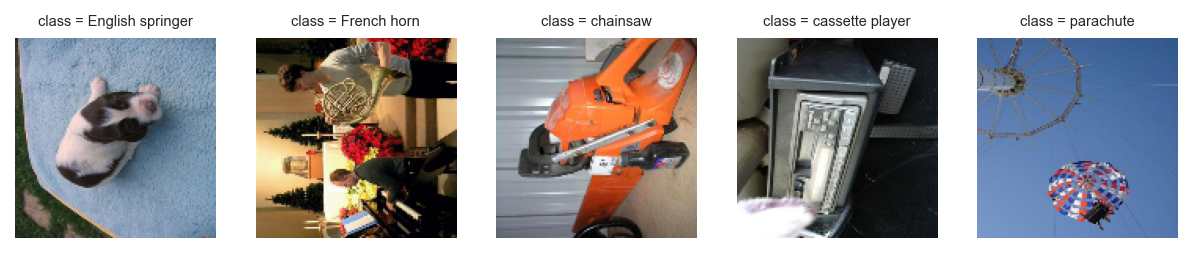

In [201]:
example_batch = plot_batch(batch, labels)

I will now plot the batch of Same Images added with noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


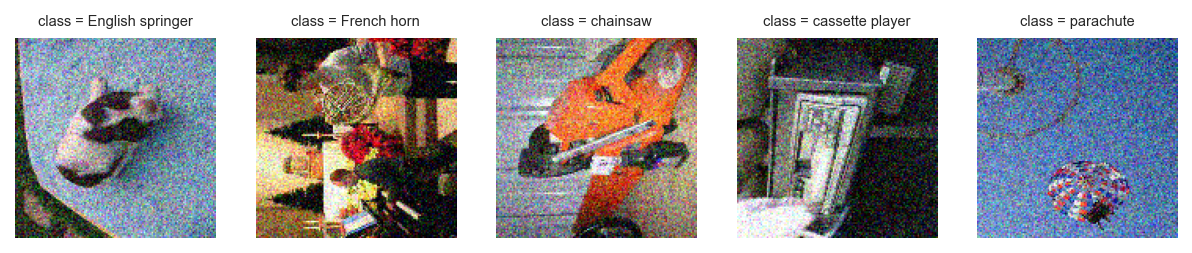

In [202]:
example_batch_noisy = plot_batch(batch_noisy, labels)

In [203]:
from torch.nn import functional as F
from pl_bolts.models.autoencoders import VAE


class MyVAE(VAE):
    def step(self, batch, batch_idx):
        x, x_noisy, y = batch
        z, x_hat, p, q = self._run_step(x_noisy)

        recon_loss = F.mse_loss(x_hat, x, reduction='mean')

        log_qz = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = log_qz - log_pz
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

In [204]:
from pytorch_lightning.callbacks import Callback

In [205]:
class VAEPrintingCallback(Callback):
    def on_train_epoch_end(
        self, trainer: "pl.Trainer", pl_module: "pl.LightningModule", unused = None
    ) -> None:
        x, x_noisy, labels = next(iter(dm.val_dataloader()))
        x_hat = trainer.model(x_noisy.cuda())
        
        images_noisy = plot_batch(x_noisy, labels)
        images_reconstructed = plot_batch(x_hat.cpu().detach(), labels)
        
        trainer.logger.experiment["epoch_evaluation_noisy"].log(File.as_image(images_noisy))
        trainer.logger.experiment["epoch_evaluation_reconstructed"].log(File.as_image(images_reconstructed))

In [206]:
trainer = pl.Trainer(
    max_epochs=350,
    progress_bar_refresh_rate=20, 
    accelerator='auto',
    #gpus=1, 
    #logger=neptune_logger,
    callbacks=[VAEPrintingCallback()]
)

C:\Users\kimay\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [207]:
model = MyVAE(input_height=IMAGE_SIZE, lr=0.001, latent_dim=4096, maxpool1=False, first_conv=True, enc_out_dim=512)

In [ ]:
trainer.fit(model, dm)

In [ ]:
run["model_vae"].upload("vae.pt")

In [208]:
batch, noisy_batch, labels = next(iter(dm.val_dataloader()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


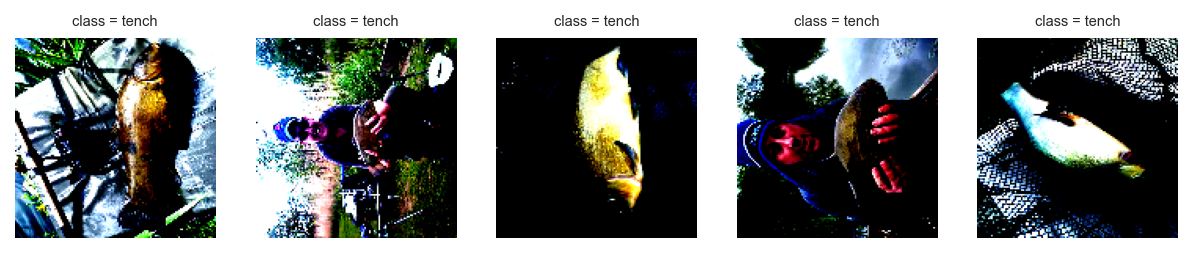

In [209]:
_ = plot_batch(batch, labels)

This is an original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


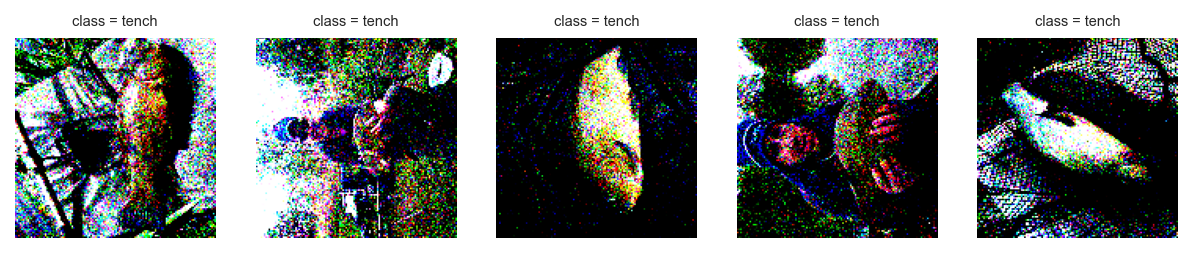

In [210]:
_ = plot_batch(noisy_batch, labels)

This is the image which contains the noise which I have been added

In [211]:
x_hat = model(noisy_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


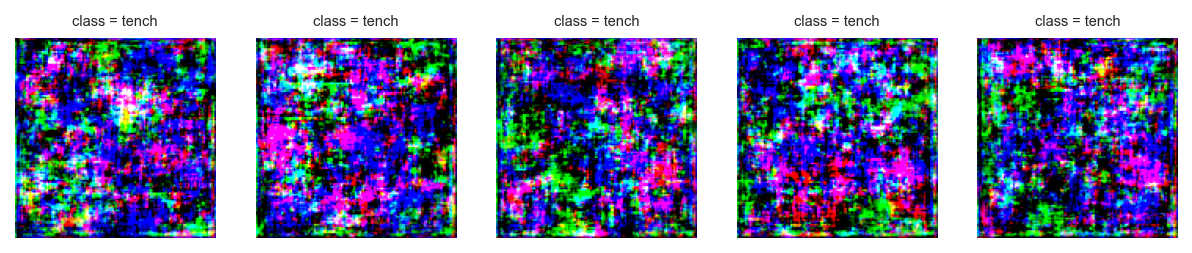

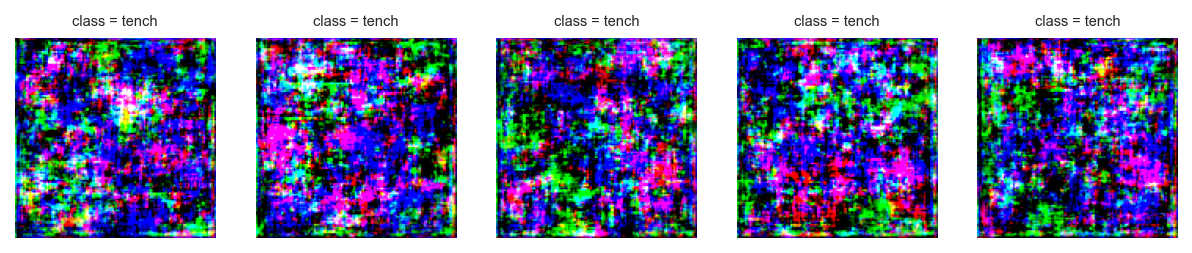

In [212]:
plot_batch(x_hat.detach(), labels)

This above image is the noise predicted by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


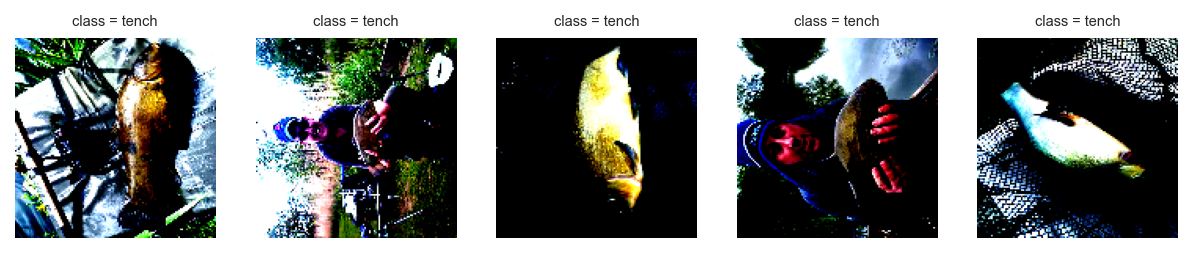

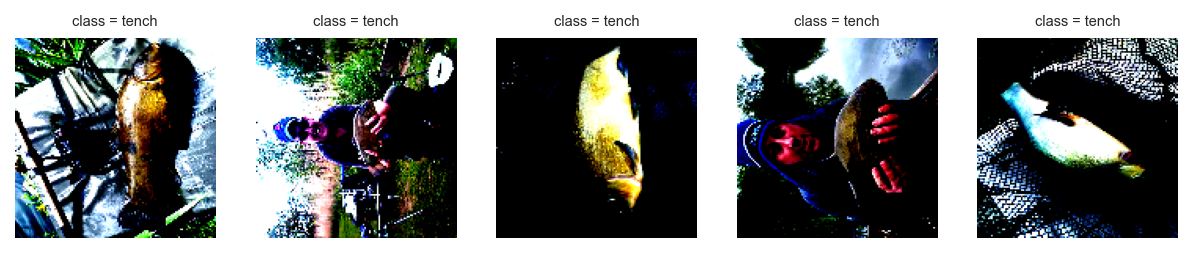

In [214]:
plot_batch((noisy_batch-x_hat).detach(),labels)

This above image is the restructed image after subtracting the noise from the noisy image.

# Conclusion
I successfully performed the Image Classification and Noise Reduction in this notebook. Various Images from the Imagenette dataset were classified according to their class labels.I used three Models which are as follows:
1)Logistic Regression
2)Random Forests 
3)Support Vector Machines 
These models were trained and tested on the dataset. I computed the metrics which were used to compare the models were Accuracy, Logloss,RMSE,MSE and AUC scores. On analysis it was observed that the best results were obtained for Random Forests with an accuracy of about 70%. In the second part I demonstrated image noising and denoising with the help of VAE(Variational Auto Encoder) model.Random Gaussian noise was added to the images to get noisy version of the images and this noise was predicted by the VAE model. On subtracting this noise from the noisy images, we were able to reconstruct the original image.


#  Reference

1. https://medium.com/jun94-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0
2. https://github.com/christianversloot/machine-learning-articles/blob/main/creating-one-vs-rest-and-one-vs-one-svm-classifiers-with-scikit-learn.md
3. Team, T. (2021, July 6). SVM in R for Data Classification using e1071 Package. TechVidvan. https://techvidvan.com/tutorials/svm-in-r/
4. https://www.datacamp.com/tutorial/understanding-logistic-regression-python
5. https://github.com/dojoteef/dvae
6. Kumar, N., Kumar, N., & Profile, V. M. C. (2019, February 23). Advantages and Disadvantages of Random Forest Algorithm in Machine Learning. The Professionals Point. http://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of-random.html
7.https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e

## License 


Copyright> (Year:-2022) <Name:Kimaya Kishor Khilare>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
